In [5]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import torch
from torch.autograd.functional import jacobian
import matplotlib.pyplot as plt

from matplotlib.collections import LineCollection
import matplotlib.colors as colors
import cProfile
import pstats

In [6]:
torch.set_default_dtype(torch.float64)
g = 10

In [93]:
def run_pendulum_energy(x,y, x_dot,y_dot, steps, stepsize):
    # using forward Euler for the pendulum
    i = 0
    lam = 0
    positions = []
    speeds = []
    energies = []
    while i < steps:
        i +=1
        positions.append(np.array([x,y]))
        x += x_dot*stepsize
        y += y_dot*stepsize
        lam = (x_dot**2 +y_dot**2 - g*y)/(2*(x**2 + y**2))
        x_dot -= (2*x*lam)*stepsize
        y_dot -= (2*y*lam + g)*stepsize
        
        energy = g*(y) + 0.5 *(x_dot**2 + y_dot**2) 
        
        energies.append(energy)
        speeds.append(speed)
    return positions, energies, speeds

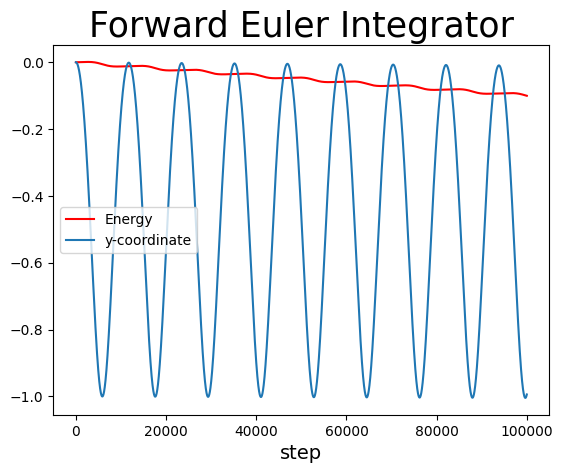

In [95]:
positions, energy , speed= run_pendulum_energy(1,0,0,0,100000,0.0001)
y = [position[1] for position in positions]
x = [position[0] for position in positions]
plt.plot(energy, color = 'red', label = 'Energy')
plt.plot(np.array(y), label = 'y-coordinate')
plt.title('Forward Euler Integrator', fontsize = 25)
plt.xlabel('step', fontsize=14)
plt.legend()
plt.savefig('euler.pdf')

Estimated period is 6.34482 s 


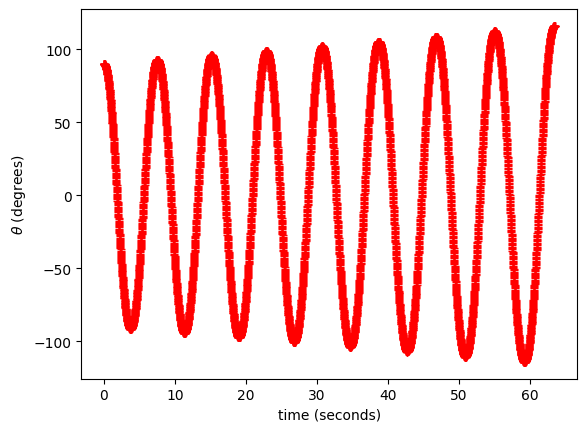

In [105]:
## Import needed modules

from pylab import *
import scipy.constants as pc


## Set initial conditions

th0 = float(input("Starting position for pendulum in degrees: "))
th0 = th0 * pi/180.	# Convert starting angle to radians
om0 = 0.0
l = 10.				# Length of pendulum in m

T_est = 2*pi*sqrt(l/pc.g)
print("Estimated period is %g s " % T_est)

N_period = float(input("Approximate number of periods to plot: "))
t_max = N_period * T_est

tau = float(input("Size of the time step (s): "))

## Solve ODE using Euler's method

th_old = th0	# Set the initial values of angular displacement, angular
                # velocity, and t (time).
om = om0
t = 0.0

th_plot = array([th_old]) # Make arrays to record the th, om, and t for plotting
om_plot = array([om])
t_plot = array([t])

while (t < t_max):
	th = th_old + om * tau					# first Euler step
	om = om - pc.g/l * sin(th_old) * tau	# second Euler step

	th_old = th	# set the angle for the next iteration
	t = t + tau	# increase the time by one time step

	th_plot = append(th_plot,th)	# append this step's result to the plotting
	                                # arrays
	om_plot = append(om_plot,om)
	t_plot = append(t_plot,t)

th_plot = th_plot*180./pi	# Convert angle back to degrees

## Plot the results
figure(1)
clf()
plot(t_plot,th_plot,'r+')
xlabel('time (seconds)')
ylabel(r'$\theta$ (degrees)')
show()

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\Tadgh\AppData\Local\Temp\ipykernel_24284\2512998216.py:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  graph.set_data(x, y)


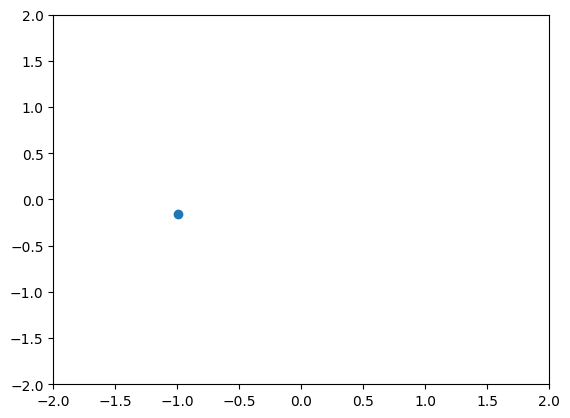

In [9]:
## making GIF
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
graph, = ax.plot([], [], 'o')

def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x = positions[i][0]
    y = positions[i][1]
    graph.set_data(x, y)
    return graph,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=True)
anim.save('pendulum.gif', writer='imagemagick')

# Constraint preserving method using Newton-Raphson

In [10]:
def newton_raphson(q_old,p_old,lam_old,step):
    '''given q^n and p^n, returns the update p^(n+1), in the case of the pendulum'''
    def fn(lam):
        t1 = torch.tensor([1.,1.])
        F = torch.tensor([0.,-10.])
        return t1 @ (q_old + step*p_old + 2*step**2*lam * q_old + step**2 *F)**2 - t1@ q_old**2

    x= lam_old
    iters =0

    while iters <40:
        x -= fn(x)/jacobian(fn, x)
        iters +=1
    return x

In [11]:
def symplectic_vectorized(q_init,p_init, lam, steps, stepsize):
    positions = []
    energies = []

    i = 0
    q = q_init
    p= p_init

    while i < steps:
        i+=1
        F = torch.tensor([0.,-10.])
        lam_b = newton_raphson(q,p,lam,stepsize) # calculating the value of lambda to enforce the constraint for the next value of q
        p += (2*q*lam_b + F)*stepsize
        q += stepsize*p
        pos= q.numpy().copy()
        positions.append(pos)
        energy = g*(q[-1]) + 0.5 *(p[0]**2 + p[-1]**2)
        energies.append(energy)
    return positions, energies

In [106]:
def non_symplectic_vectorized(q_init,p_init, lam, steps, stepsize):
    positions = []
    i = 0
    q = q_init
    p= p_init

    energies = []
    while i < steps:
        i+=1
        F = torch.tensor([0.,-10.])

        q += stepsize*p
        lam_b = newton_raphson(q,p,lam,stepsize) # calculating the value of lambda to enforce the constraint for the next value of q
        p += (2*q*lam_b + F)*stepsize

        pos= q.numpy().copy()
        positions.append(pos)
        energy = g*(q[-1]) + 0.5 *(p[0]**2 + p[-1]**2)
        energies.append(energy)
    return positions, energies

In [108]:
positions_non_symp, non_symp_energies = non_symplectic_vectorized(torch.tensor([1.,0]),torch.tensor([0.,0.]), torch.tensor([0.]),100000,0.1)
plt.title('Symplectic Euler integrator', fontsize = 25)
y_non_symp = [position[1] for position in positions_non_symp]
x_non_symp  = [position[0] for position in positions_non_symp]
plt.plot(non_symp_energies, color = 'red', label = 'Energy')
plt.plot(np.array(y_non_symp), label = 'y-coordinate')
plt.xlabel('steps', fontsize =14)
plt.legend()
plt.savefig('symplectic_pendulum.pdf')

KeyboardInterrupt: 

In [96]:
positions_symp, symp_energies = symplectic_vectorized(torch.tensor([1.,0]),torch.tensor([0.,0.]), torch.tensor([0.]),100000,0.0001)
y_symp = [position[1] for position in positions_symp]
x_symp  = [position[0] for position in positions_symp]
plt.plot(symp_energies, color = 'red', label = 'Energy')
plt.plot(np.array(y_symp), label = 'y-coordinate')
plt.legend()

KeyboardInterrupt: 

MovieWriter imagemagick unavailable; using Pillow instead.
C:\Users\Administrator\AppData\Local\Temp\ipykernel_10072\969345133.py:13: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  graph.set_data(x, y)


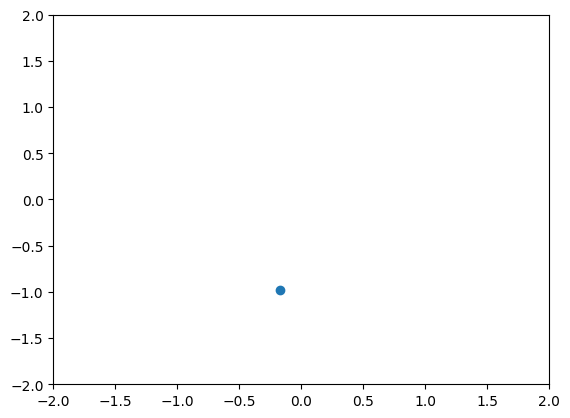

In [16]:
# making a GIF for this integrator
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
graph, = ax.plot([], [], 'o')

def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x = positions_symp[i][0]
    y = positions_symp[i][1]
    graph.set_data(x, y)
    return graph,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=True)
anim.save('pendulum_symp.gif', writer='imagemagick')

# Making a plot to compare the two

In [17]:
xs_1 = [tensor[0] for tensor in positions]
ys_1 = [tensor[1] for tensor in positions]

points_1 = np.vstack((xs_1, ys_1)).T.reshape(-1, 1, 2)
segments_1 = np.hstack((points_1[:-1], points_1[1:]))
alphas_1 = np.flip(np.linspace(1,len(xs_1), len(xs_1)))

In [18]:
xs_2 = [ tensor[0] for tensor in positions_symp]
ys_2 = [ tensor[1] for tensor in positions_symp]

points_2 = np.vstack((xs_2, ys_2)).T.reshape(-1, 1, 2)
segments_2 = np.hstack((points_2[:-1], points_2[1:]))
alphas_2 = np.flip(np.linspace(1,len(xs_1), len(xs_1)))

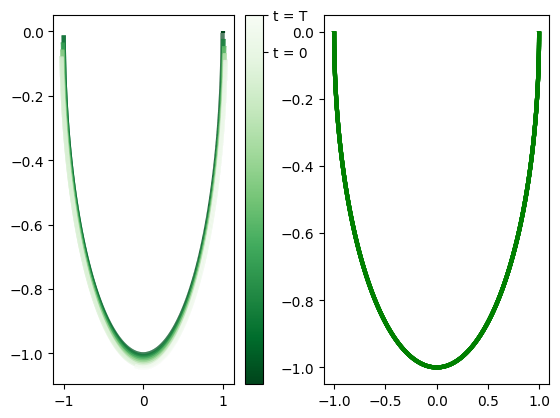

In [19]:
fig, axs = plt.subplots(1,2)

lc1 = LineCollection(segments_1, array=alphas_1,cmap = 'Greens', lw=3)
line1 = axs[0].add_collection(lc1)
axs[0].autoscale()

lc2 = LineCollection(segments_2, array=alphas_2, color="Green", lw=3)
line2 = axs[1].add_collection(lc2)
cbar = fig.colorbar(line1, ticks=[1, 1000])
cbar.ax.set_yticklabels(['t = T', 't = 0'])
cbar.ax.invert_yaxis()
axs[1].autoscale()

plt.savefig('pendulum.pdf')

# Implementing SHAKE and RATTLE

In [17]:
def G(gs):
    '''
    :param gs: a list of tensor functions
    :return: a function sending a tensor to the stacked matrix of the functions of that tensor
    '''

    def G_gs(tensor):
        # print("Function input: ",tensor) # checking the input for debugging
        # print("Function output:" , torch.stack([g(tensor) for g in gs],0))
        return torch.stack([g(tensor) for g in gs], 0)

    return G_gs

In [18]:
def J(gs, x):
    '''Returns the Jacobian evaluated at x for a list gs of constraint functions'''
    return jacobian(G(gs), x)

In [19]:
def shake_step(x, v1, h, M, gs, e):
    '''
    Defining a function to take a step in the position, velocity form.
    g should be a vector-valued function of constraints.
    :return: x_1, v_1
    '''

    #print(f"x = {x}, v1 = {v1}")
    G1 = G(gs)

    DV = np.zeros_like(x)
    DV[-1] = 10  # gravity acts in the last dimension
    DV_col = DV.reshape(-1, 1)

    x_col = x.reshape(-1, 1)
    v1_col = v1.reshape(-1, 1)

    x2 = x_col + h * v1_col - h ** 2 * torch.inverse(M) @ DV_col

    Q_col = x2
    Q = torch.squeeze(Q_col)
    Dg_Q = J(gs, Q)
    Dg_q = J(gs, x)
    t = Dg_q[0, :].reshape(-1, 1)

    while torch.all(torch.abs(G1(Q)) > e):
        for i in range(len(gs)):
            t = Dg_q[i, :].reshape(-1, 1)
            Dg_Q = J(gs, Q)
            dL = gs[i](Q) / (Dg_Q[i, :] @ torch.inverse(M) @ Dg_q[i, :].reshape(-1, 1))
            edit = (torch.inverse(M) @ Dg_q[i, :].reshape(-1, 1)) * dL
            Q = torch.squeeze(Q_col - (torch.inverse(M) @ Dg_q[i, :].reshape(-1, 1) * dL))
            Q_col = Q.reshape(-1, 1)
    v2 = (Q_col - x_col) / h
    return Q, v2

In [20]:
def shake_simulator(x_init, v_init, h, M, gs, its):
    xs = [x_init]
    vs = [v_init]
    x = x_init
    v1 = v_init
    F = torch.tensor([0.,-10.])
    energy = 1/2 * torch.dot(torch.squeeze(v_init), torch.squeeze(v_init)) + torch.dot(torch.squeeze(x_init), F)
    energies = [energy]
    for i in range(its):
        x, v1 = shake_step(x, v1, h, M, gs, 10 ** (-8))
        last_x = xs[-1]
        xs.append(x)
        last_v = vs[-1]
        vs.append(v1)
        v_n1 = 1/2 * (torch.squeeze(last_v) + torch.squeeze(v1))
        energy = 1/2 * torch.dot(torch.squeeze(v_n1),torch.squeeze(v_n1)) + torch.dot(torch.squeeze(last_x), -F)
        energies.append(energy)
    return xs, vs, energies

In [97]:
x_init = torch.tensor([1., 0.])  # a point which is on the curve
v_init = torch.tensor([0., 0.])  # starting with velocity zero
h = 0.0001
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1 ]
M = torch.eye(2)
its = 100
#x = shake_step(x_init, v_init , h, M, gs, 10**(-4))
positions_shake, vs_shake, energies_shake = shake_simulator(x_init, v_init, h, M, gs, 100000)

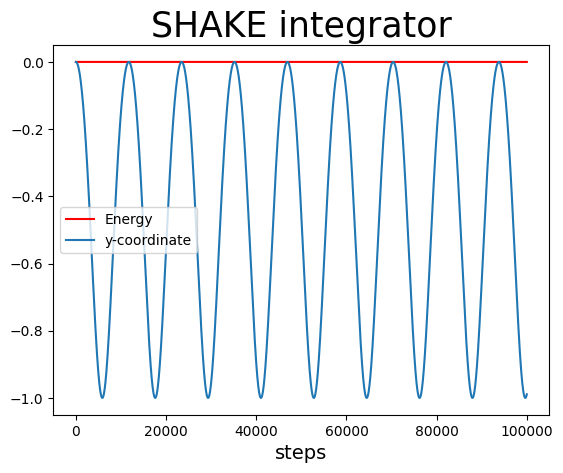

In [98]:
y_shake = [position[1] for position in positions_shake]
x_rattle  = [position[0] for position in positions_shake]
plt.plot(energies_shake, color = 'red', label = 'Energy')
plt.plot(np.array(y_shake), label = 'y-coordinate')
plt.xlabel('steps', fontsize = 14)
plt.title('SHAKE integrator', fontsize = 25)
plt.legend()
plt.savefig('shake_pendulum.pdf')

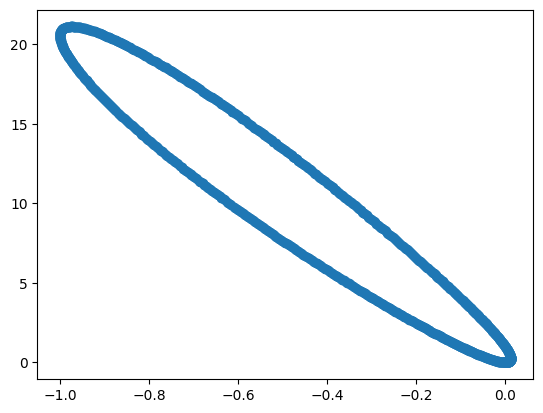

In [26]:
x = [v[0].item() for v in positions_shake]
y = [v[1].item() for v in positions_shake]
v_x = [v[0].item() for v in vs_shake]
v_y = [v[1].item() for v in vs_shake]
# plt.plot(v_x[0:100], color = 'red')
# plt.plot(v_y[0:100], color = 'green')
plt.scatter(y,(np.array(v_x)**2 +np.array(v_y)**2))

In [27]:
# making a GIF for this integrator
# fig = plt.figure()
# ax = plt.axes(xlim=(-100, 100), ylim=(-100, 100))
# graph, = ax.plot([], [], 'o', markersize = 10)
#
# x = np.linspace(-10,10,50)
# line, = ax.plot(x,x**3 - x**2+1)
# def init():
#     graph.set_data([], [])
#     return graph,
#
# def animate(i):
#     x = positions[i][0]
#     y = positions[i][1]
#     graph.set_data(x, y)
#     return graph,line
#
#
# anim = FuncAnimation(fig, animate, init_func=init,
#                                frames=1000, interval=1, blit=True)
# anim.save('rollercoaster_pendulum.gif', writer='Pillow')

In [28]:
def rattle_step(x, v1, h, M, gs, e , lamb):
    '''
    Defining a function to take a step in the position, velocity form.
    g should be a vector-valued function of constraints.
    :return: x_1, v_1
    '''

    G1 = G(gs)


    DV = np.zeros_like(x)
    #DV[-1] = 10  # leaving this out for g-BAOAB
    DV_col = DV.reshape(-1, 1)

    x_col = x.reshape(-1, 1)
    v1_col = v1.reshape(-1, 1)

    # doing Newton-Raphson iterations
    lam = lamb
    iters = 0
    x2 = x_col + h * v1_col - 0.5*(h**2)* torch.inverse(M) @ DV_col
    Q_col = x2
    Q = torch.squeeze(Q_col)
    J1 = J(gs, torch.squeeze(x_col))


    while iters <100:
        J2 = J(gs, torch.squeeze(Q))
        R = J2 @ torch.inverse(M) @ J1.t()
        dL = torch.inverse(R) @ G1(Q)
        #print(f"Q = {Q}")
        Q -= torch.inverse(M) @ J1.t() @ dL
        iters +=1

    #print(f"Updating v1_col, Jacobian {J(gs,torch.squeeze(x_col))}")
    #print(f"Updating v1_col, Jacobian^T {J(gs,torch.squeeze(x_col)).t()}")

    # half step for velocity
    Q_col = Q.reshape(-1,1)
    v1_half = (Q_col - x_col)/h
    x_col = Q_col
    J1 = J(gs, torch.squeeze(x_col))

    # getting the level
    J2 = J(gs, torch.squeeze(Q))
    P = J1 @ torch.inverse(M) @ J1.t()
    T = J1 @ (2/h * v1_half - torch.inverse(M) @ DV_col)

    #solving the linear system
    L = torch.linalg.solve(P,T)

    v1_col = v1_half - h/2 * DV_col - h/2 * J2.t()@L


    # print(f"Error = {G1(x_col + h*( v1_col + h/2 * torch.inverse(M) @ J1.reshape(-1,1) @ lam))}")
    # # updating v
    # print(f"lam = {lam}")
    # print(f"Updating v1_col, Jacobian^T {J(gs,torch.squeeze(x_col)).t}")

    return torch.squeeze(x_col), torch.squeeze(v1_col)

In [29]:
# x_col = torch.tensor([[4.],[47.]])
# v1_col = torch.tensor([[-1.],[1.]])
# DV_col = np.zeros_like(x_col)
#
# h = 2 ** (-6)
# gs = [lambda x: x[0] ** 3 - x[0] ** 2 - 1 - x[1]]
# M = torch.eye(2)
# lamb = torch.tensor([0.])
# G1 = G(gs)
# def q_update(lam):
#     #print(f"lam ={lam}")
#     J1 = J(gs, torch.squeeze(x_col))
#     #print(f"J1 = {J1}")
#     return G1(x_col + h*( v1_col + h/2 * torch.inverse(M) @ J1.reshape(-1,1) @ lam))
#
# # doing Newton-Raphson iterations
# lam = lamb
# iters = 0
# J1 = J(gs, torch.squeeze(x_col))
# print(f"Error = {G1(x_col + h*( v1_col + h/2 * torch.inverse(M) @ J1.reshape(-1,1) @ lam))}")
#
# x2 = x_col + h * v1_col - 0.5*(h**2)* torch.inverse(M) @ DV_col
# Q_col = x2
# Q = torch.squeeze(Q_col)
#
#
# while iters <40:
#     J2 = J(gs, torch.squeeze(x_col))
#     R = J1 @ torch.inverse(M) @ J2.t()
#     dL = torch.inverse(R) @ G1(Q)
#     Q -= torch.inverse(M) @ J2.t() @ dL
#     iters +=1
#     print(f"Error = {G1(Q)}")
# # updating v

In [33]:
def rattle_simulator(x_init, v_init, h, M, gs, its):
    xs = [x_init]
    vs = [v_init]
    F = torch.tensor([0.,-10.])
    energy = 1/2 * torch.dot(torch.squeeze(v_init), torch.squeeze(v_init)) + torch.dot(torch.squeeze(x_init), F)
    energies = [energy]
    x = x_init
    v1 = v_init
    for i in range(its):
        x, v1 = rattle_step(x, v1, h, M, gs, 10 ** (-8), torch.zeros(len(gs)))
        energy = 1/2 * torch.dot(v1,v1) + torch.dot(x, -F)
        xs.append(x)
        vs.append(v1)
        energies.append(energy)
    return xs, vs, energies

In [34]:
x_init = torch.tensor([[1.],[0.]])
v_init = torch.tensor([[0.],[0.]])
h = 0.1
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1]
M = torch.eye(2)
lamb = torch.tensor([0.])
its = 100

positions_rattle, velocities, energies_rattle = rattle_simulator(x_init, v_init, h, M, gs, its)

In [37]:
positions_rattle

[tensor([[1.],
         [0.]]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),
 tensor([1., 0.]),

In [44]:
y_rattle

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

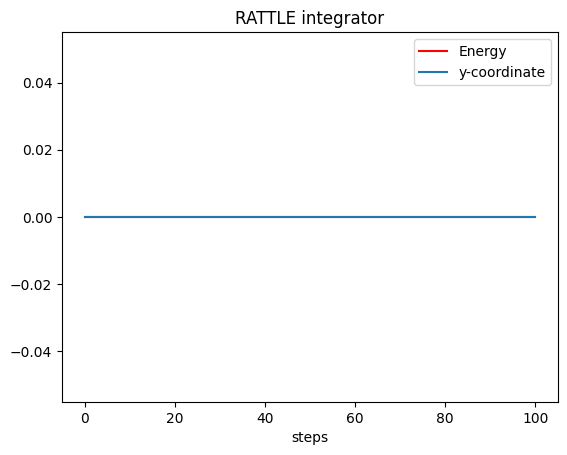

In [43]:
y_rattle = [position[1].item() for position in positions_rattle]
x_rattle  = [position[0].item() for position in positions_rattle]
plt.title("RATTLE integrator")
plt.plot(energies_rattle, color = 'red', label = 'Energy')
plt.plot(y_rattle, label = 'y-coordinate')
plt.xlabel('steps')
plt.legend()
plt.savefig('rattle_pendulum.pdf')

In [ ]:
# making a GIF for this integrator
fig = plt.figure()
ax = plt.axes(xlim=(-100, 100), ylim=(-100, 100))
graph, = ax.plot([], [], 'o', markersize = 10)

x = np.linspace(-10,10,50)
line, = ax.plot(x,x**3 - x**2-1)
def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x = positions[i][0]
    y = positions[i][1]
    graph.set_data(x, y)
    return graph,line


anim = FuncAnimation(fig, animate, init_func=init,
                               frames=1000, interval=1, blit=True)
anim.save('rollercoaster_pendulum_rattle.gif', writer='Pillow')

# Langevin Dynamics

In [ ]:
def gBAOAB_step(q_init,p_init,F, gs, h,M, gamma, k):

    # setting up variables
    R = torch.rand(len(q_init))
    p = p_init
    q = q_init
    a2 = torch.exp(torch.tensor(-gamma*h/2))
    b2 = torch.sqrt(k*(1-a2**2))

    # doing the initial p-update
    J1 = J(gs, torch.squeeze(q))
    P = J1 @ torch.inverse(M) @ J1.t()
    T = J1 @  (torch.inverse(M) @ p - h/2 * torch.inverse(M) @ F(q))

    mu = torch.linalg.solve(-P,T)
    p = p + h/2 * F(q) +  J1.t() @ mu


    # doing the first RATTLE step
    q, p = rattle_step(q, p, h, M, gs, 10**(-4) , torch.zeros(len(q)))


    # the second p-update
    J2 = J(gs, torch.squeeze(q))
    P2 = J2 @ torch.inverse(M) @ J2.t()
    T2 = J2 @  (a2*p + b2* M**(1/2) @ R)
    mu2 = torch.linalg.solve(-P2,T2)

    p = a2* p + b2* M**(1/2) @ R +  J2.t() @ mu2


    # doing the second RATTLE step
    q, p = rattle_step(q, p, h, M, gs, 10**(-4) , torch.zeros(len(q)))


    # the final p update
    J3 = J(gs, torch.squeeze(q))
    P3 = J3 @ torch.inverse(M) @ J3.t()
    T3 = J3 @ (torch.inverse(M) @ p - h/2 * torch.inverse(M) @ F(q))
    mu3 = torch.linalg.solve(-P3,T3)
    p = a2* p + b2* M**(1/2) @ R +  J3.t() @ mu3


    return q,p

In [ ]:
def gBAOAB_step_exact(q_init,p_init,F, gs, h,M, gamma, k):

    # setting up variables
    R = torch.rand(len(q_init))
    p = p_init
    q = q_init
    a2 = torch.exp(torch.tensor(-gamma*h))
    b2 = torch.sqrt(k*(1-a2**(2)))

    # doing the initial p-update
    J1 = J(gs, torch.squeeze(q))
    G = J1
    L1 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p -=  h * L1 @ F(q)


    # doing the first RATTLE step
    q, p = rattle_step(q, p, h, M, gs, 10**(-4) , torch.zeros(len(q)))


    # the second p-update - (O-step in BAOAB)
    J2 = J(gs, torch.squeeze(q))
    G = J2
    L2 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p = a2* p + b2* M**(1/2) @L2 @ M**(1/2) @ R

    # doing the second RATTLE step
    q, p = rattle_step(q, p, h, M, gs, 10**(-4) , torch.zeros(len(q)))


    # the final p update
    J3 = J(gs, torch.squeeze(q))
    G = J3
    L3 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
    p -=  h * L3 @ F(q)

    return q,p

In [ ]:
# def gBAOAB_step_exact(q_init,p_init,F, gs, h,M, gamma, k):
#
#     # setting up variables
#     R = torch.rand(len(q_init))
#     p = p_init
#     q = q_init
#     a2 = torch.exp(torch.tensor(-gamma*h))
#     b2 = torch.sqrt(k*(1-a2**(2)))
#
#     # doing the initial p-update
#     J1 = J(gs, torch.squeeze(q))
#     G = J1
#     print("Shape of factor: ", (torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)).size())
#     L1 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
#     print("L1 = ", L1)
#     print("F(q) = ",F(q))
#     print(f"Shape of F: {F(q).size()}")
#     p -=  h * L1 @ torch.squeeze(F(q))
#
#
#     # doing the first RATTLE step
#     q, p = rattle_step(q, p, h, M, gs, 10**(-4) , torch.zeros(len(q)))
#
#
#     # the second p-update - (O-step in BAOAB)
#     J2 = J(gs, torch.squeeze(q))
#     G = J2
#     L2 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
#     p = a2* p + b2* M**(1/2) @L2 @ M**(1/2) @ R
#
#     # doing the second RATTLE step
#     q, p = rattle_step(q, p, h, M, gs, 10**(-4) , torch.zeros(len(q)))
#
#
#     # the final p update
#     J3 = J(gs, torch.squeeze(q))
#     G = J3
#     L3 = torch.eye(len(q_init)) - torch.transpose(G,0,1) @ torch.inverse(G@ torch.inverse(M)@ torch.transpose(G,0,1)) @ G @ torch.inverse(M)
#     p -=  h * L3 @ torch.squeeze(F(q))
#
#     return q,p

In [ ]:
def gBAOAB_integrator(q_init,p_init,F, gs, h,M, gamma, k, steps):
    positions = []
    velocities = []
    q = q_init
    p = p_init
    for i in range(steps):
        q, p = gBAOAB_step_exact(q,p, F,gs, h,M, gamma, k)
        positions.append(q)
        velocities.append(p)

    return positions, velocities

In [ ]:
def potential(x):
    return torch.linalg.norm(x)**2

In [ ]:
def force(x):
    return jacobian(potential, x)

In [ ]:
force(torch.tensor([1.,2.,3.]))

In [ ]:
x_init = torch.tensor([[4.],[47.]])
v_init = torch.tensor([[-1.],[1.]])

h = 2 ** (-6)
gs = [lambda x: x[0] ** 3 - x[0] ** 2 - 1 - x[1]]
M = torch.eye(2)
lamb = torch.tensor([0.])
its = 1000
F = force
positions, velocities = gBAOAB_integrator(x_init,v_init, force,gs, h,M, 1, 1, 10)

In [ ]:
# making a GIF for this integrator
fig = plt.figure()
ax = plt.axes(xlim=(-100, 100), ylim=(-100, 100))
graph, = ax.plot([], [], 'o', markersize = 10)

x = np.linspace(-10,10,50)
line, = ax.plot(x,x**3 - x**2-1)
def init():
    graph.set_data([], [])
    return graph,

def animate(i):
    x = positions[i][0]
    y = positions[i][1]
    graph.set_data(x, y)
    return graph,line


anim = FuncAnimation(fig, animate, init_func=init,
                               frames=10, interval=1, blit=True)
anim.save('rollercoaster_pendulum_rattle.gif', writer='Pillow')

# Trying a particular distribution

In [ ]:
x_init = torch.tensor([[1.],[0.]])
v_init = torch.tensor([[0.],[0.]])

h = 2 ** (-6)
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1]
M = torch.eye(2)
lamb = torch.tensor([0.])
its = 1000
F = force
positions, velocities = gBAOAB_integrator(x_init,v_init, force,gs, h,M, 1, 1, 1000)

In [ ]:
xs = [v[0] for v in velocities]
ys = [v[1] for v in velocities]
plt.plot(xs)
plt.plot(ys)

In [ ]:
xs = [pos[0] for pos in positions]
ys = [pos[1] for pos in positions]

plt.hist2d(xs,ys,bins =200, range = [[-2, 2], [-2, 2]])

In [ ]:
# making a GIF for this integrator
fig = plt.figure()
ax = plt.axes(xlim=(-2, 2), ylim=(-2, 2))
graph, = ax.plot([], [], 'o', markersize=10)

x = np.linspace(-10, 10, 50)
Drawing_uncolored_circle = plt.Circle( (0, 0 ),
                                      1 ,
                                      fill = False )
ax.add_artist( Drawing_uncolored_circle )


def init():
    graph.set_data([], [])
    return graph,


def animate(i):
    x = positions[i][0]
    y = positions[i][1]
    graph.set_data(x, y)
    return graph, line


anim = FuncAnimation(fig, animate, init_func=init,
                     frames=1000, interval=1, blit=True)
anim.save('pendulum_rattle.gif', writer='Pillow')

# 1d normal distribution

In [ ]:
def potential_norm(x):
    return -torch.log((torch.sqrt(torch.tensor([2]))* torch.pi)**(-1) * torch.exp(-1/2 * x[0]**2))

def force_norm(x):
    return jacobian(potential, x)

x_init = torch.tensor([[1.],[1.]])
v_init = torch.tensor([[0.],[0.]])
h = 2 ** (-6)
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1 ]
M = torch.eye(2)
lamb = torch.tensor([0.])
its = 1000
positions, velocities = gBAOAB_integrator(x_init,v_init, force_norm,gs, h,M, 1, 1, 100)

In [ ]:
print(force_norm(x_init))

In [ ]:
xs = [pos[0] for pos in positions]
ys = [pos[1] for pos in positions]

plt.hist2d(xs,ys, bins = 500,range = [[-2, 2], [-2, 2]],cmap=plt.cm.Reds)

In [ ]:
from torch.autograd.functional import jacobian

def potential_norm_vec(x):
    '''
    the potential function for the univariate normal
    '''
    return torch.stack([-torch.log((torch.sqrt(torch.tensor([2]))* torch.pi)**(-1) * torch.exp(-1/2 * x[i]**2)) for i in range(0, len(x), 2)])

def force_norm_vec(x):
    #x_tup = tuple(x) # converting the list of position vectors to a tuple so that the jacobian function can handle it
    return jacobian(potential_norm_vec, x)

# Bingham- Von Mises- Fisher Distribution

In [ ]:
c = torch.tensor([1.,.5])
A = torch.tensor([[1.,2.],[2.,1.]])
def potential_BVMF(x):
    return -c@x - torch.squeeze(A@x)@x

def force_BVMF(x):
    return torch.squeeze(jacobian(potential_BVMF, x), dim = 0)

x_init = torch.tensor([[1.],[0.]])
v_init = torch.tensor([[0.],[0.]])
h = 2 ** (-6)
gs = [lambda x: x[0] ** 2 + x[1] ** 2 - 1 ]
M = torch.eye(2)
lamb = torch.tensor([0.])
its = 1000
positions, velocities = gBAOAB_integrator(x_init,v_init, force_BVMF,gs, h,M, 1, 1, 1000)

In [ ]:
cProfile.run("gBAOAB_integrator(x_init,v_init, force_BVMF,gs, h,M, 1, 1, 1000)", "my_func_stats")

In [ ]:
p = pstats.Stats("my_func_stats")
p.sort_stats("cumulative").print_stats()

In [ ]:
xs = [pos[0] for pos in positions]
ys = [pos[1] for pos in positions]
plt.hist2d(xs,ys, bins = 100,range = [[-1.5, 1.5], [-1.5, 1.5]],cmap=plt.cm.Reds)

In [ ]:
potentials =  [potential_BVMF(pos) for pos in positions]
avgs=np.cumsum(potentials)/range(1,len(potentials)+1)
plt.plot(avgs)

# Trying to use torch.JIT

In [ ]:
@torch.jit.script
def force_norm_vec(x):
    #x_tup = tuple(x) # converting the list of position vectors to a tuple so that the jacobian function can handle it
    return jacobian(potential_norm_vec, x)